## **Data processing**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection
from imblearn.combine import SMOTEENN
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, RandomizedSearchCV
from sklearn.metrics import balanced_accuracy_score



In [2]:
# from google.colab import files
# invoice = files.upload()
# client = files.upload()
invoice = pd.read_csv('../datasets/invoice.csv')
client = pd.read_csv('../datasets/client.csv')



In [3]:
invoice.rename(columns={'date': 'date_invoice'}, inplace=True)
client.rename(columns={'date': 'date_client'}, inplace=True)

In [4]:
client.isna().sum()

region         0
date_client    0
dis            0
id             0
catg           0
target         0
dtype: int64

In [5]:
merged_df = pd.merge(invoice, client, on='id', how='left')

In [6]:
client_10_th = merge_df = merged_df[merged_df['id'] == 10]
client_10_th.head()

,id,date_invoice,tarif_type,counter_statue,reading_remarque,consommation_level_4,months_number,counter_type,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,region,date_client,dis,catg,target
0,10,15/2/2010,11,0,8,0,4,ELEC,1,407,0,0,301,13/3/1986,62,11,0
1,10,6/3/2015,11,0,8,0,8,ELEC,1,815,0,0,301,13/3/1986,62,11,0
2,10,13/2/2009,11,0,6,0,4,ELEC,1,569,0,0,301,13/3/1986,62,11,0
3,10,2/5/2019,11,0,9,0,12,ELEC,1,2400,682,0,301,13/3/1986,62,11,0
4,10,30/5/2017,11,0,8,0,4,ELEC,1,188,0,0,301,13/3/1986,62,11,0


## **EDA**



**Fraud Distribuition**

In [7]:
client_0 = merged_df[merged_df['target'] == 0]['id'].nunique()
client_1 = merged_df[merged_df['target'] == 1]['id'].nunique()

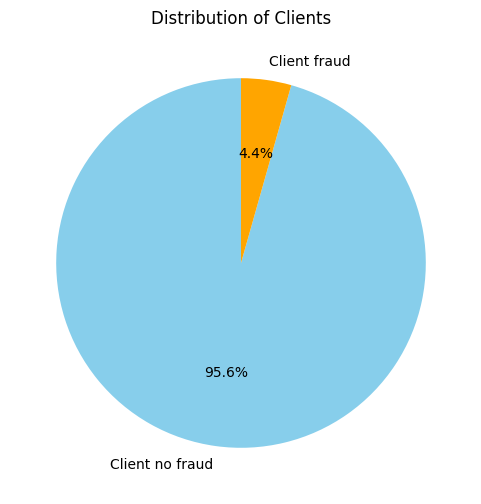

In [8]:
data = [client_0, client_1]
labels = ['Client no fraud', 'Client fraud']
# Plotting the pie chart
plt.figure(figsize=(6, 6))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Distribution of Clients')
plt.show()

In [7]:
merge_columns = merged_df.columns.tolist()
# for col in ['date_invoice', 'date_client', 'id','target']:
#     if col in merge_columns:
#         merge_columns.remove(col)
# print(merge_columns)

In [9]:
def plot_distribution(merge_df: pd.DataFrame, column: str, title: str):
    plt.figure(figsize=(10, 5))
    sns.countplot(x=column, data=merge_df)
    plt.title(title)
    plt.show()

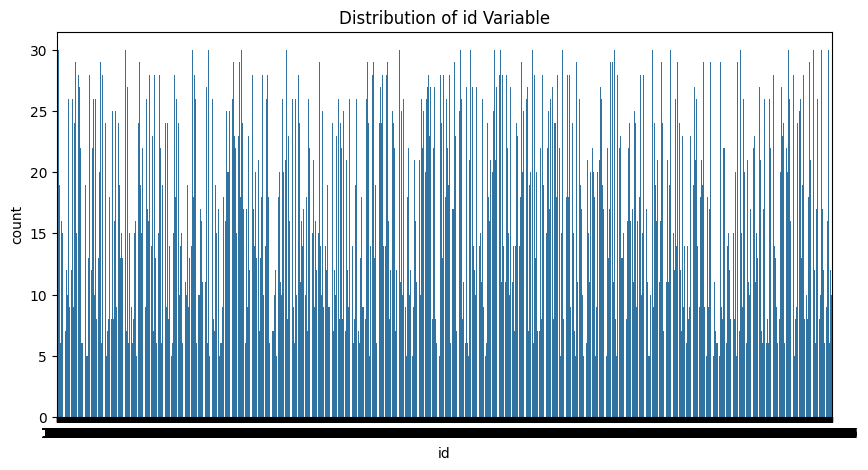

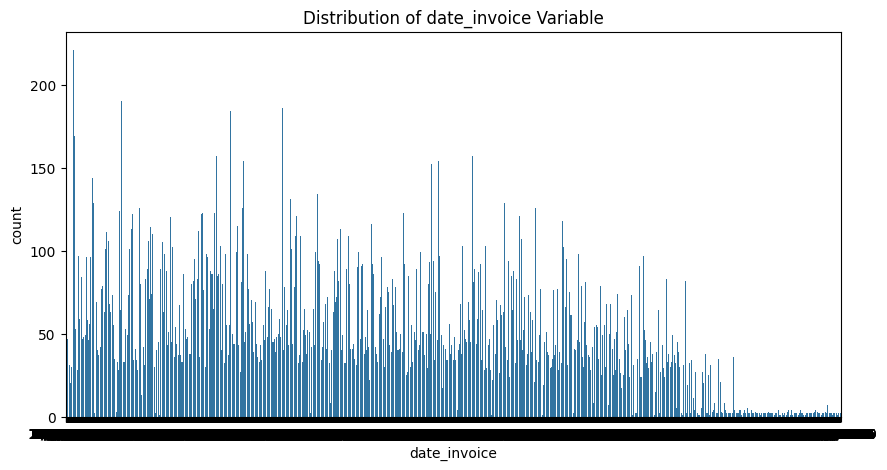

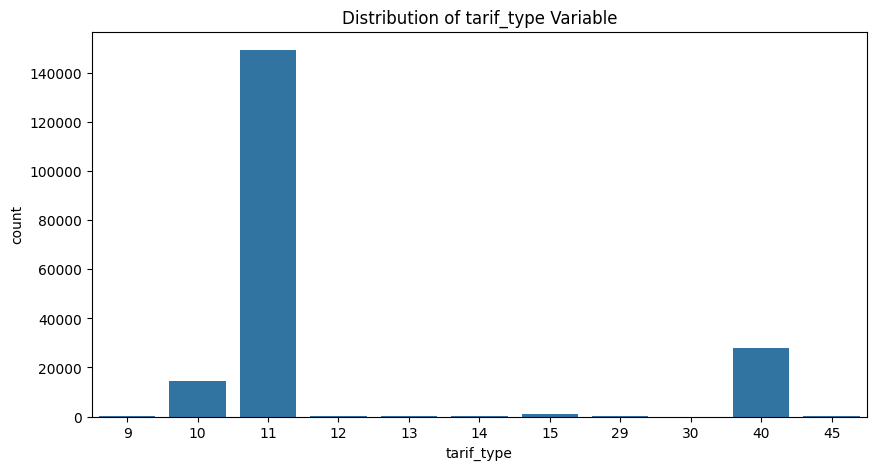

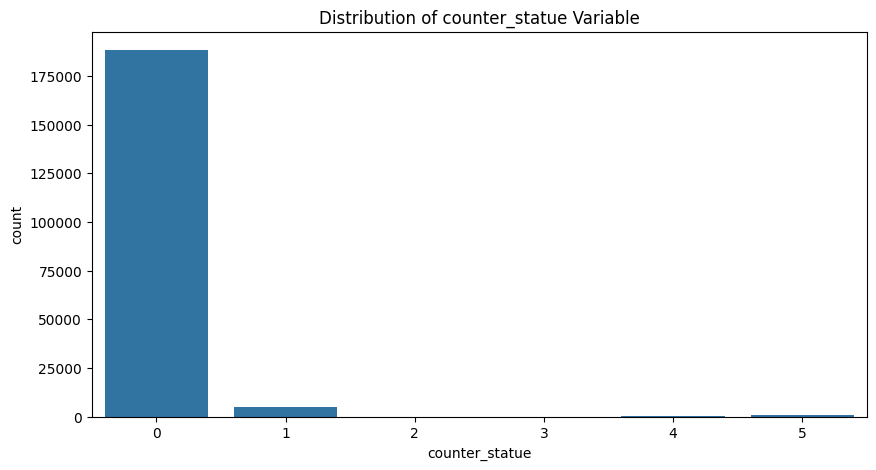

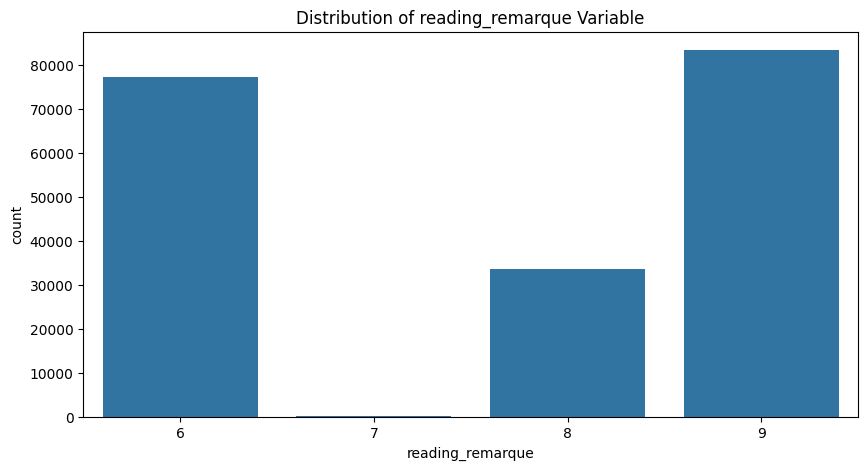

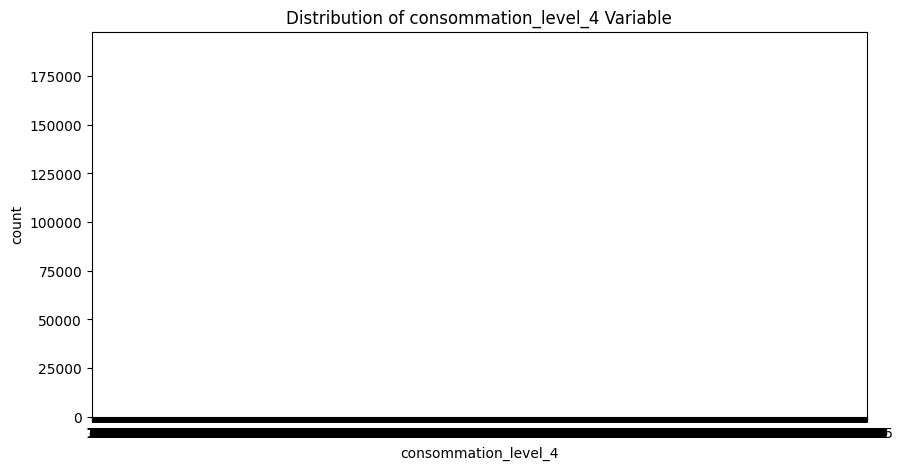

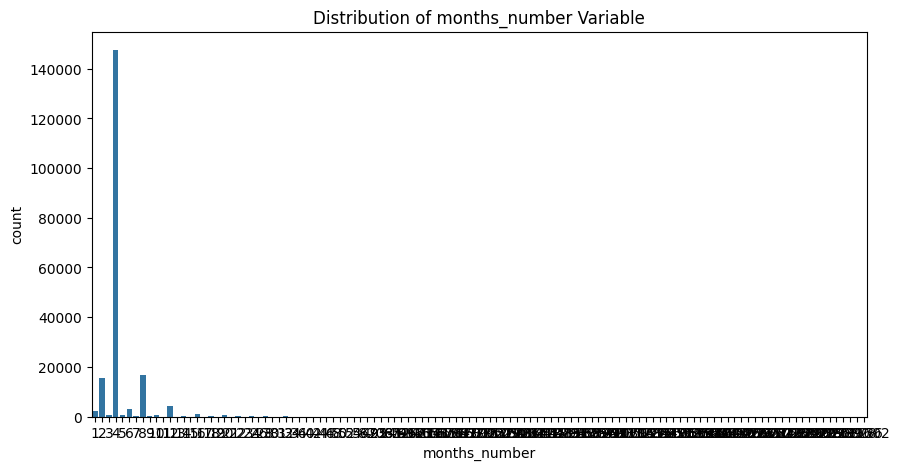

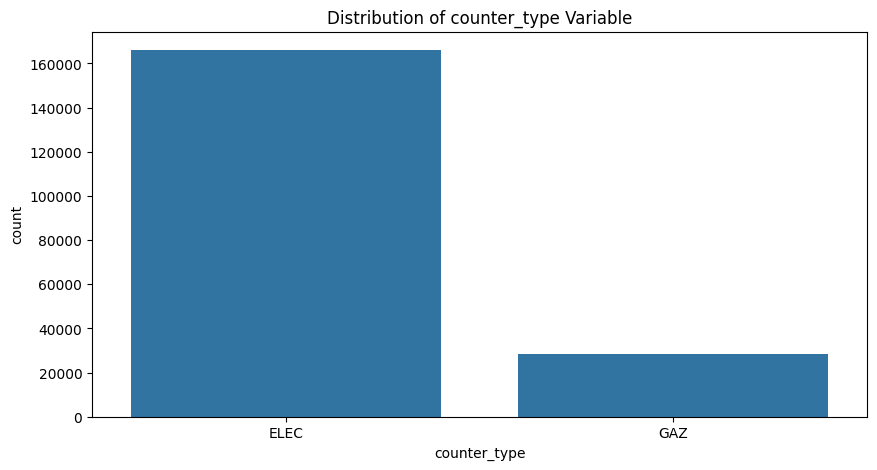

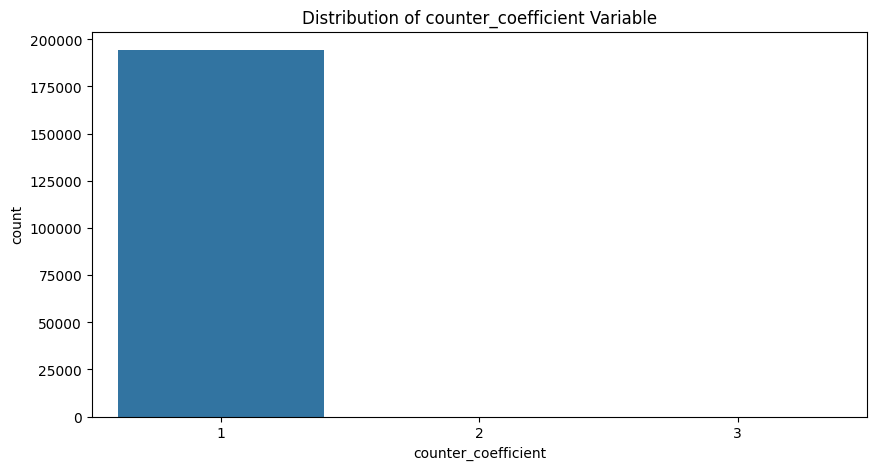

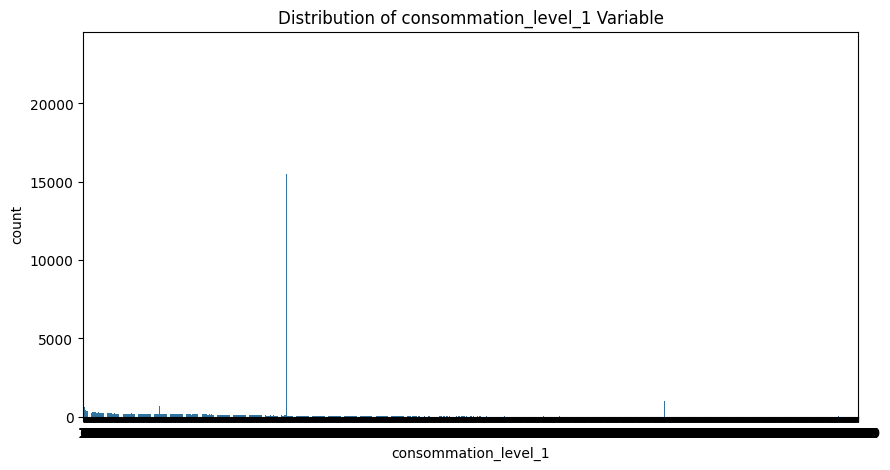

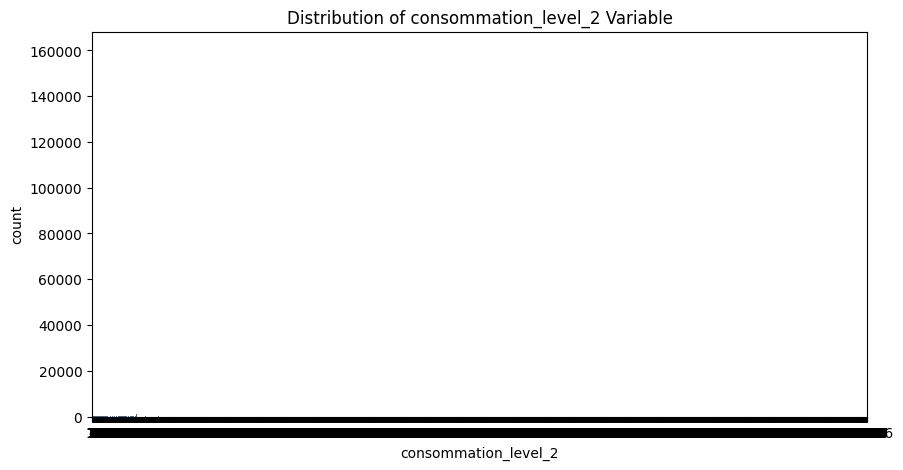

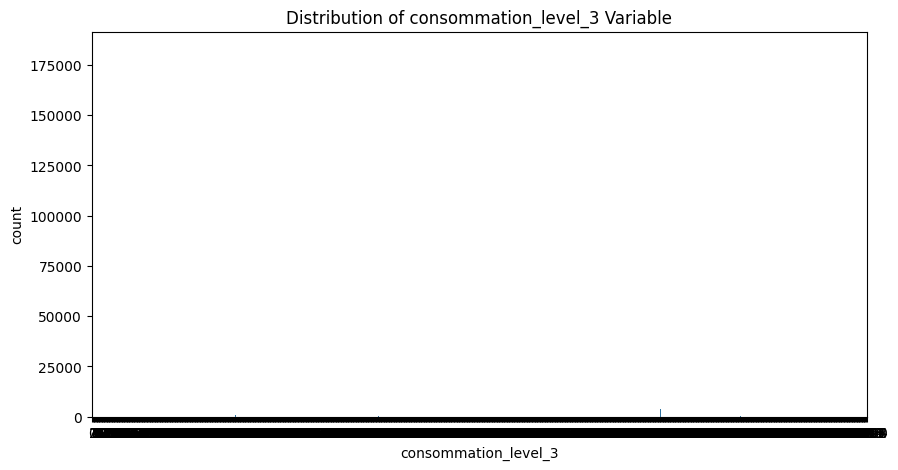

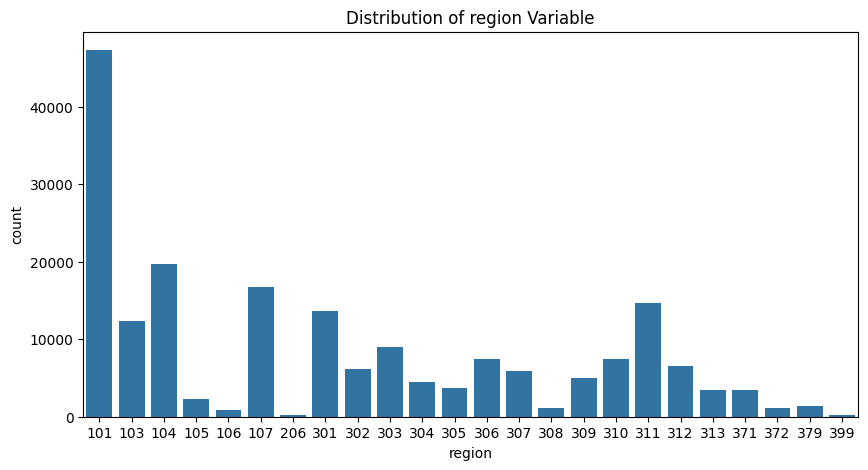

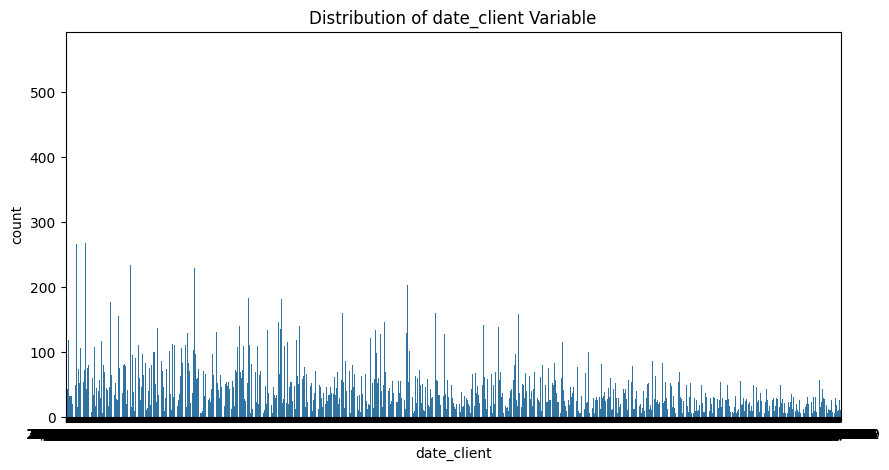

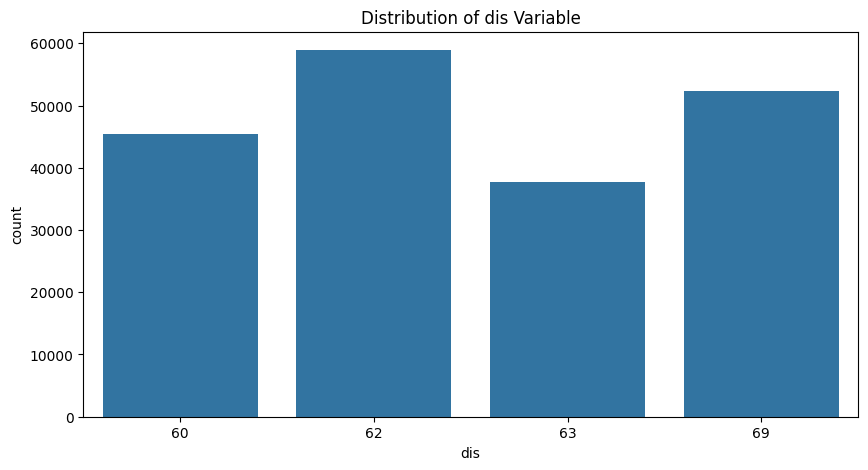

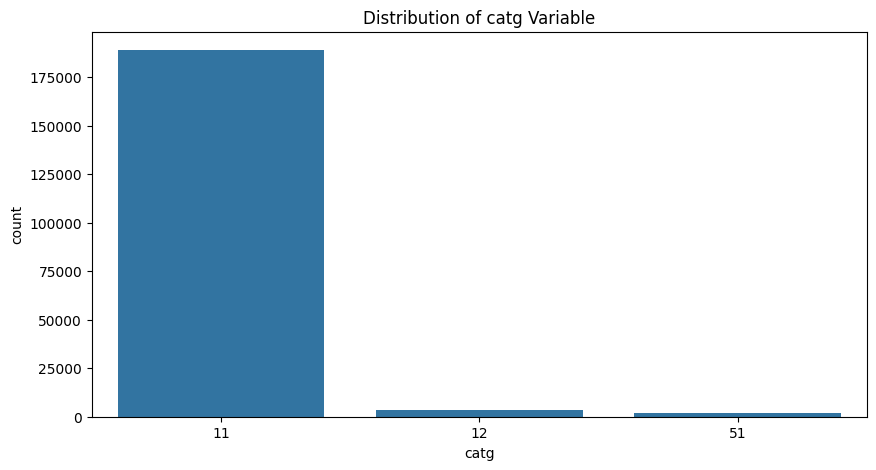

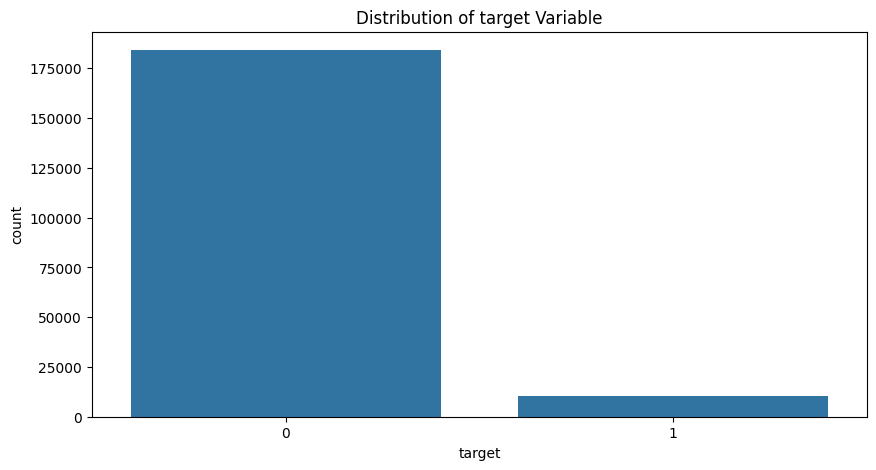

In [10]:
for column in merge_columns:
    plot_distribution(merged_df, column, f'Distribution of {column} Variable')

Train-test split

In [105]:
# Train test split on clients - 80% train 20% test, stratified on target variable

y = client['target']
X = client['id']

X_train_id, X_test_id, y_train, y_test = train_test_split(
    X, y, stratify = y, test_size = 0.2, random_state = 1
)

# print(X_train)
X_train_merged = pd.merge(X_train_id,
                          merged_df,
                        on = 'id',
                        how = 'inner'
                )

X_test_merged = pd.merge(X_test_id,
                          merged_df,
                        on = 'id',
                        how = 'inner'
                )

#y_train = X_train_merged['target']
X_train = X_train_merged.drop(columns = ['target'])
#y_test = X_test_merged['target']
X_test = X_test_merged.drop(columns = ['target'])
print(X_train.columns)

Index(['id', 'date_invoice', 'tarif_type', 'counter_statue',
       'reading_remarque', 'consommation_level_4', 'months_number',
       'counter_type', 'counter_coefficient', 'consommation_level_1',
       'consommation_level_2', 'consommation_level_3', 'region', 'date_client',
       'dis', 'catg'],
      dtype='object')


In [106]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(155308, 16)
(9392,)
(39066, 16)
(2349,)


Data pre-processing


In [ ]:
#Do data pre-processing on train set (Mainly one-hot encoding of categorical variables, and Scaling, separate year,month,day for date),
#and then perform the same steps on the test set as two blocks of codes

## **Feature Engineering**


### One hot encoding


In [107]:
def one_hot_encode(df, column_names, drop_original=True, prefix=None):
    for column_name in column_names:
        one_hot = pd.get_dummies(df[column_name], prefix=column_name)
        df = pd.concat([df, one_hot], axis=1)
        if drop_original:
            df.drop(columns=[column_name], inplace=True)
    return df

In [ ]:
# columns_to_encode = ['counter_type', 'dis', 'catg','region']
# merged_df = one_hot_encode(merged_df, columns_to_encode, drop_original=True)

### Feature construction

In [108]:
import pandas as pd
import numpy as np

def construct_features(merged_df):

    # 1. Group by id and keep one hot encoding
    grouped = merged_df.groupby('id')
    one_hot_columns = [col for col in merged_df.columns if col.startswith(('counter_type', 'dis', 'catg','region'))]
    one_hot_features = grouped[one_hot_columns].first()

    # 2. Calculate statistics for consommation levels
    consommation_columns = ['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4', 'counter_coefficient', 'reading_remarque']
    consommation_stats = grouped[consommation_columns].agg(['mean', 'max', 'min', 'std'])

    # 3. Calculate median, max, and mean of decimal months between consecutive date_invoice
    merged_df['date_invoice'] = pd.to_datetime(merged_df['date_invoice'], dayfirst=True)
    merged_df['date_diff'] = merged_df.groupby('id')['date_invoice'].diff().dt.days / 30.0  # Convert days to decimal months
    date_diff_stats = grouped['date_diff'].agg(['median', 'max', 'mean'])

    # 4. Calculate the length (decimal months) from date_client to the latest date_invoice
    merged_df['date_client'] = pd.to_datetime(merged_df['date_client'], dayfirst=True)
    merged_df['client_to_latest'] = (merged_df['date_invoice'] - merged_df['date_client']).dt.days / 30.0
    client_to_latest = grouped['client_to_latest'].max()

    final_features = pd.concat([one_hot_features, consommation_stats, date_diff_stats, client_to_latest], axis=1)
    final_features.columns = [
    '_'.join(col) if isinstance(col, tuple) else col
    for col in final_features.columns
    ]
    return final_features

### Feature scaling

In [ ]:
def standardisation(df, column_name):
  for column in column_name:
    df[column] = (df[column] - df[column].mean()) / df[column].std()
  return df


In [111]:
#Performing data preprocessing, feature engineering, and feature scaling on train set
columns_to_encode = ['counter_type', 'dis', 'catg','region']
standardised_column = ['consommation_level_1_mean',
       'consommation_level_1_max', 'consommation_level_1_min',
       'consommation_level_1_std', 'consommation_level_2_mean',
       'consommation_level_2_max', 'consommation_level_2_min',
       'consommation_level_2_std', 'consommation_level_3_mean',
       'consommation_level_3_max', 'consommation_level_3_min',
       'consommation_level_3_std', 'consommation_level_4_mean',
       'consommation_level_4_max', 'consommation_level_4_min',
       'consommation_level_4_std', 'counter_coefficient_mean',
       'counter_coefficient_max', 'counter_coefficient_min',
       'counter_coefficient_std', 'reading_remarque_mean',
       'reading_remarque_max', 'reading_remarque_min', 'reading_remarque_std',
       'median', 'max', 'mean', 'client_to_latest']

print(X_train.shape)
X_train_preprocessed = one_hot_encode(X_train, columns_to_encode, drop_original = True ,prefix=None)
X_train_preprocessed = construct_features(X_train_preprocessed)
X_train_preprocessed = standardisation(X_train_preprocessed, standardised_column)


print(X_train_preprocessed.shape)
print(y_train.shape)


(155308, 16)
(9392, 61)
(9392,)


Feature selection

In [113]:

no_cols = X_train_preprocessed.shape[1]

sfs = SequentialFeatureSelector(
    estimator = LogisticRegression(random_state = 2),
    k_features = (1, no_cols),
    scoring = 'roc_auc',
    cv = 5
)
print(len(X_train_preprocessed))


sfs.fit(X_train_preprocessed, y_train)

9392


SequentialFeatureSelector(estimator=LogisticRegression(random_state=2),
                          k_features=(1, 61), scoring='roc_auc')

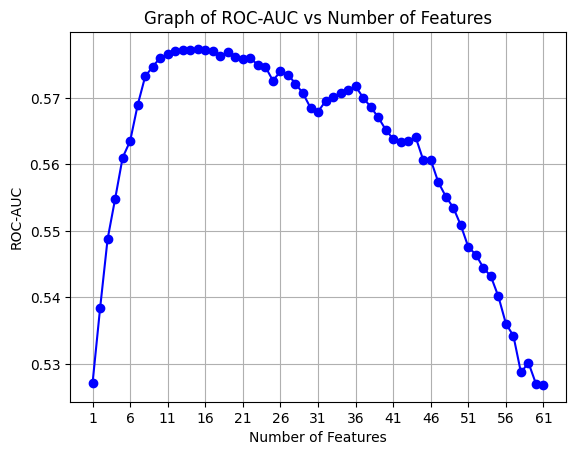

In [114]:
optimal_feature_graph = plot_sequential_feature_selection(sfs.get_metric_dict(), kind = None)
plt.title('Graph of ROC-AUC vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC')
plt.xticks(ticks = range(1, no_cols + 1, 5),)
plt.grid()
plt.show()


#optimal number of features: 11 - from the elbow

In [115]:
#Performing sequential feature selection to select 'optimal' number of features to train our model
sfs = SequentialFeatureSelector(
    estimator = LogisticRegression(random_state = 12),
    k_features = 11,
    scoring = 'roc_auc'
)

sfs.fit(X_train_preprocessed, y_train)

SequentialFeatureSelector(estimator=LogisticRegression(random_state=12),
                          k_features=(11, 11), scoring='roc_auc')

In [116]:
#obtain the names of the optimal features and filter them for our training and test set
features_to_use = list(sfs.k_feature_names_)
print(features_to_use)
X_train_feature_selection = X_train_preprocessed[features_to_use]

print(X_train_feature_selection.shape) #verify the number of columns
print(y_train.shape)


['counter_type_ELEC', 'counter_type_GAZ', 'region_103', 'region_302', 'region_304', 'region_305', 'region_308', 'region_311', 'region_371', 'consommation_level_1_min', 'consommation_level_2_std']
(9392, 11)
(9392,)


Imbalanced dataset handling - SMOTEENN

In [117]:
#As dataset is imbalanced, we perform smoteenn on our training dataset to artifically generate a relatively balanced number of datapoints for each 'target' on the train set
smote = SMOTEENN(random_state = 1)

X_train_aft_smote, y_train_aft_smote = smote.fit_resample(X_train_feature_selection, y_train)
print(y_train_aft_smote.value_counts())

/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


target
0    6039
1    3606
Name: count, dtype: int64


In [118]:
#perform feature processing steps on test set
columns_to_encode = ['counter_type', 'dis', 'catg','region']
X_test_preprocessed = one_hot_encode(X_test, columns_to_encode, drop_original = True ,prefix=None)
X_test_preprocessed = construct_features(X_test_preprocessed)
X_test_preprocessed = standardisation(X_test_preprocessed, standardised_column)

X_test_feature_selection = X_test_preprocessed[features_to_use]


print(X_test_feature_selection.shape)
print(y_test.shape)

(2349, 11)
(2349,)


Machine Learning


In [ ]:
#Logistic regression - vanilla model
lr  = LogisticRegression(random_state = 1)

#5 fold cross validation as required
y_pred = cross_val_predict(lr, X_train_aft_smote, y_train_aft_smote, cv = 5)
print(f"Cross validation for model: \n {classification_report(y_train_aft_smote, y_pred)} \n")
#ROC AUC score
roc_auc_score = cross_val_score(lr, X_train_aft_smote, y_train_aft_smote, cv = 5, scoring = 'roc_auc')
print(f'ROC AUC Score for Logistic Regression vanilla model after 5 fold cross validation: {roc_auc_score.mean()} \n\n')

lr.fit(X_train_aft_smote, y_train_aft_smote)
y_pred = lr.predict(X_test_feature_selection)
print(f"Model result on test dataset: \n {classification_report(y_test, y_pred)}\n\n")

#Getting average recall of each class
balanced_acc_score = balanced_accuracy_score(y_test, y_pred)
print(f"Average Recall Score: {balanced_acc_score}")




Cross validation for model: 
               precision    recall  f1-score   support

           0       0.68      0.90      0.77      6039
           1       0.63      0.28      0.39      3606

    accuracy                           0.67      9645
   macro avg       0.65      0.59      0.58      9645
weighted avg       0.66      0.67      0.63      9645
 

ROC AUC Score for Logistic Regression vanilla model after 5 fold cross validation: 0.6826159495922057 


Model result on test dataset: 
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      2246
           1       0.06      0.18      0.09       103

    accuracy                           0.84      2349
   macro avg       0.51      0.53      0.50      2349
weighted avg       0.92      0.84      0.88      2349



Average Recall Score: 0.528786883261721


In [157]:
#SVM - vanilla model

svm = SVC(random_state =  1)

#5 fold cross validation as required
y_pred = cross_val_predict(svm, X_train_aft_smote, y_train_aft_smote, cv = 5)
print(f"Cross validation for model: \n {classification_report(y_train_aft_smote, y_pred)} \n\n")
#ROC AUC score
roc_auc_score = cross_val_score(svm, X_train_aft_smote, y_train_aft_smote, cv = 5, scoring = 'roc_auc')
print(f'ROC AUC Score for SVM vanilla model after 5 fold cross validation: {roc_auc_score.mean()} \n\n')

svm.fit(X_train_aft_smote, y_train_aft_smote)
y_pred = svm.predict(X_test_feature_selection)
print(f"Model result on test dataset: \n {classification_report(y_test, y_pred)}\n\n")

#Getting average recall of each class
balanced_acc_score = balanced_accuracy_score(y_test, y_pred)
print(f"Average Recall Score: {balanced_acc_score}")

Cross validation for model: 
               precision    recall  f1-score   support

           0       0.69      0.91      0.79      6039
           1       0.69      0.32      0.44      3606

    accuracy                           0.69      9645
   macro avg       0.69      0.62      0.61      9645
weighted avg       0.69      0.69      0.66      9645
 


ROC AUC Score for SVM vanilla model after 5 fold cross validation: 0.748488608770717 


Model result on test dataset: 
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      2246
           1       0.06      0.23      0.10       103

    accuracy                           0.82      2349
   macro avg       0.51      0.54      0.50      2349
weighted avg       0.92      0.82      0.86      2349



Average Recall Score: 0.5376980867821111


In [138]:
#XGBoost - vanilla model
#Set to binary logistic as we are dealing with a classification problem that takes on two values - fraud or non-fraud
xgb = XGBClassifier(random_state = 1, objective = 'binary:logistic')

#5 fold cross validation as required
y_pred = cross_val_predict(xgb, X_train_aft_smote, y_train_aft_smote, cv = 5)
print(f"Cross validation for model: \n {classification_report(y_train_aft_smote, y_pred)} \n\n")
#ROC AUC score
roc_auc_score = cross_val_score(xgb, X_train_aft_smote, y_train_aft_smote, cv = 5, scoring = 'roc_auc')
print(f'ROC AUC Score for XGB Classifier vanilla model after 5 fold cross validation: {roc_auc_score.mean()} \n\n')

xgb.fit(X_train_aft_smote, y_train_aft_smote)
y_pred = xgb.predict(X_test_feature_selection)
print(f"Model result on test dataset: \n {classification_report(y_test, y_pred)}\n\n")

#Getting average recall of each class
balanced_acc_score = balanced_accuracy_score(y_test, y_pred)
print(f"Average Recall Score: {balanced_acc_score}")

Cross validation for model: 
               precision    recall  f1-score   support

           0       0.94      0.95      0.95      6039
           1       0.92      0.91      0.91      3606

    accuracy                           0.94      9645
   macro avg       0.93      0.93      0.93      9645
weighted avg       0.94      0.94      0.94      9645
 


ROC AUC Score for XGB Classifier vanilla model after 5 fold cross validation: 0.9781093071492546 


Model result on test dataset: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      2246
           1       0.04      0.13      0.06       103

    accuracy                           0.82      2349
   macro avg       0.50      0.49      0.48      2349
weighted avg       0.91      0.82      0.86      2349



Average Recall Score: 0.48897500626788504


Hyperparameter tuning

In [ ]:
#Logistic Regression - Randomized Search for efficiency

logistic_regression_hyperparam_dic = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'max_iter': [100, 500, 1000, 10000],
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [{0: 1, 1: i} for i in range(1, 11)] + ['balanced']
}

randomized_search = RandomizedSearchCV(
    estimator = LogisticRegression(random_state = 1),
    param_distributions = logistic_regression_hyperparam_dic,
    n_iter = 30,
    cv = 5,
    scoring = 'f1'
)

randomized_search.fit(X_train_aft_smote, y_train_aft_smote)

best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
print(f'Best hyperparameters for logistic regression: {best_params} \n Score: {best_score} \n\n')

#Using the best estimators to predict on the test set
lr_best = randomized_search.best_estimator_
y_pred_best = lr_best.predict(X_test_feature_selection)
print(f"Model result on test dataset: \n {classification_report(y_test, y_pred_best)}\n\n")

#Getting average recall of each class 
balanced_acc_score = balanced_accuracy_score(y_test, y_pred_best)
print(f"Average Recall Score: {balanced_acc_score}")

Best hyperparameters for logistic regression: {'penalty': 'l2', 'max_iter': 1000, 'class_weight': {0: 1, 1: 2}, 'C': 0.01} 
 Score: 0.5880693527950368 


Model result on test dataset: 
               precision    recall  f1-score   support

           0       0.96      0.60      0.73      2246
           1       0.05      0.43      0.08       103

    accuracy                           0.59      2349
   macro avg       0.50      0.51      0.41      2349
weighted avg       0.92      0.59      0.71      2349



Average Recall Score: 0.5116777183169215


/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
105 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/linear_m

In [158]:
#SVM - Randomized Search for efficiency

svm_hyperparam_dic = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [i for i in range(1, 11)],
    'gamma': [0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000],
    'C': [0.01, 0.1, 1, 10],
    'class_weight': [{0: 1, 1: i} for i in range(1, 11)] + ['balanced']
}

randomized_search = RandomizedSearchCV(
    estimator = SVC(random_state = 1),
    param_distributions = svm_hyperparam_dic,
    n_iter = 30,
    cv = 5,
    scoring = 'f1'
)

randomized_search.fit(X_train_aft_smote, y_train_aft_smote)

best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
print(f'Best hyperparameters for logistic regression: {best_params} \n Score: {best_score} \n\n')

#Using the best estimators to predict on the test set
svm_best = randomized_search.best_estimator_
y_pred_best = svm_best.predict(X_test_feature_selection)
print(f"Model result on test dataset: \n {classification_report(y_test, y_pred_best)}\n\n")

#Getting average recall of each class 
balanced_acc_score = balanced_accuracy_score(y_test, y_pred_best)
print(f"Average Recall Score: {balanced_acc_score}")

/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/iggyten/Desktop/i

Best hyperparameters for logistic regression: {'max_iter': 500, 'kernel': 'linear', 'gamma': 1, 'degree': 8, 'class_weight': {0: 1, 1: 3}, 'C': 0.01} 
 Score: 0.5443429443478202 


Model result on test dataset: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      2246
           1       0.04      1.00      0.08       103

    accuracy                           0.04      2349
   macro avg       0.02      0.50      0.04      2349
weighted avg       0.00      0.04      0.00      2349



Average Recall Score: 0.5


/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/iggyten/Desktop/it1244_proj/venv/lib/python3.9/site-packages

In [159]:
#XGBoost - Randomized Search for efficiency

xgb_hyperparam_dic = {
    'learning_rate': [0.001, 0.01, 0.1, 1, 10],
    'n_estimators': [100, 500, 1000, 2000],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.5, 0.75, 1],
    'gamma': [0, 0.01, 0.1],
    'colsample_bytree': [0.5, 0.75, 1]
}

randomized_search = RandomizedSearchCV(
    estimator = XGBClassifier(random_state = 1, objective = 'binary:logistic'),
    param_distributions = xgb_hyperparam_dic,
    n_iter = 30,
    cv = 5,
    scoring = 'f1'
)

randomized_search.fit(X_train_aft_smote, y_train_aft_smote)

best_params = randomized_search.best_params_
best_score = randomized_search.best_score_
print(f'Best hyperparameters for logistic regression: {best_params} \n Score: {best_score} \n\n')

#Using the best estimators to predict on the test set
xgb_best = randomized_search.best_estimator_
y_pred_best = xgb_best.predict(X_test_feature_selection)
print(f"Model result on test dataset: \n {classification_report(y_test, y_pred_best)}\n\n")

#Getting average recall of each class 
balanced_acc_score = balanced_accuracy_score(y_test, y_pred_best)
print(f"Average Recall Score: {balanced_acc_score}")

Best hyperparameters for logistic regression: {'subsample': 1, 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.75} 
 Score: 0.9238410920940776 


Model result on test dataset: 
               precision    recall  f1-score   support

           0       0.96      0.84      0.90      2246
           1       0.05      0.17      0.08       103

    accuracy                           0.82      2349
   macro avg       0.50      0.51      0.49      2349
weighted avg       0.92      0.82      0.86      2349



Average Recall Score: 0.509684963127545
